In [104]:
import time
import random
import math
import numpy as np
import pandas as pd
from src.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
df = pd.read_excel('satisfaction.xlsx')

# faster than encoding
df_2 = pd.get_dummies(df,drop_first=True)

X = df_2.iloc[:, range(1,9)].values
y = df_2.iloc[:, 0].values


# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [106]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (48000, 8)
Validation data shape:  (1000, 8)
Test data shape:  (1000, 8)
dev data shape:  (500, 8)


In [107]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(48000, 9) (1000, 9) (1000, 9) (500, 9)


### Stochastic Gradient Descent


In [108]:
from src.classifiers.softmax import SoftmaxClassifier

# The SoftmaxClassifier class inherits from LinearClassifier
softmax = SoftmaxClassifier()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                          num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 3.291087
iteration 100 / 1500: loss 1.990624
iteration 200 / 1500: loss 1.742472
iteration 300 / 1500: loss 1.658083
iteration 400 / 1500: loss 1.626523
iteration 500 / 1500: loss 1.615440
iteration 600 / 1500: loss 1.613376
iteration 700 / 1500: loss 1.610680
iteration 800 / 1500: loss 1.609721
iteration 900 / 1500: loss 1.609596
iteration 1000 / 1500: loss 1.608925
iteration 1100 / 1500: loss 1.609644
iteration 1200 / 1500: loss 1.609366
iteration 1300 / 1500: loss 1.610442
iteration 1400 / 1500: loss 1.609587
That took 0.273752s


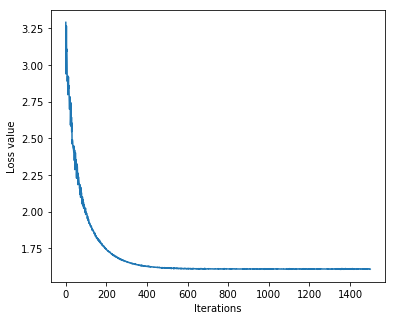

In [109]:
# A useful debugging strategy is to plot the loss as a function of iterations:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

Write the `LinearClassifier.predict` method and evaluate the performance on both the training and validation set:

In [ ]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.200083
validation accuracy: 0.209000


### Training Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength and learning rate).

In [ ]:
from src.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax, results, all_classifiers = softmax_hyperparameter_tuning(X_train, y_train, X_val, y_val)

In [ ]:
# Visualize the validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# if you want to take a look at the other classifiers assign them to best_softmax here
sorted_classifiers = sorted(all_classifiers, key=lambda x : x[1])
best_softmax = sorted_classifiers[-1][0]

In [ ]:
from src.model_savers import save_softmax_classifier
from src.classifiers.softmax import SoftmaxClassifier

save_softmax_classifier(best_softmax)